In [1]:
%pip install pandas seaborn matplotlib 

You should consider upgrading via the '/Users/tenzin/Desktop/mycodes/nba-draft-ranker/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from pathlib import Path

current_dir = Path.cwd()
draft_dir = current_dir.parent / "drafts"

files = list(draft_dir.glob("draft_20*.csv"))

df = pd.DataFrame()
for file in files:
    curr_df = pd.read_csv(file)
    df = pd.concat([df, curr_df])

df = df.sort_values(by=["SEASON", "OVERALL_PICK"]) 
df.to_csv(draft_dir / "drafts.csv", index=False)

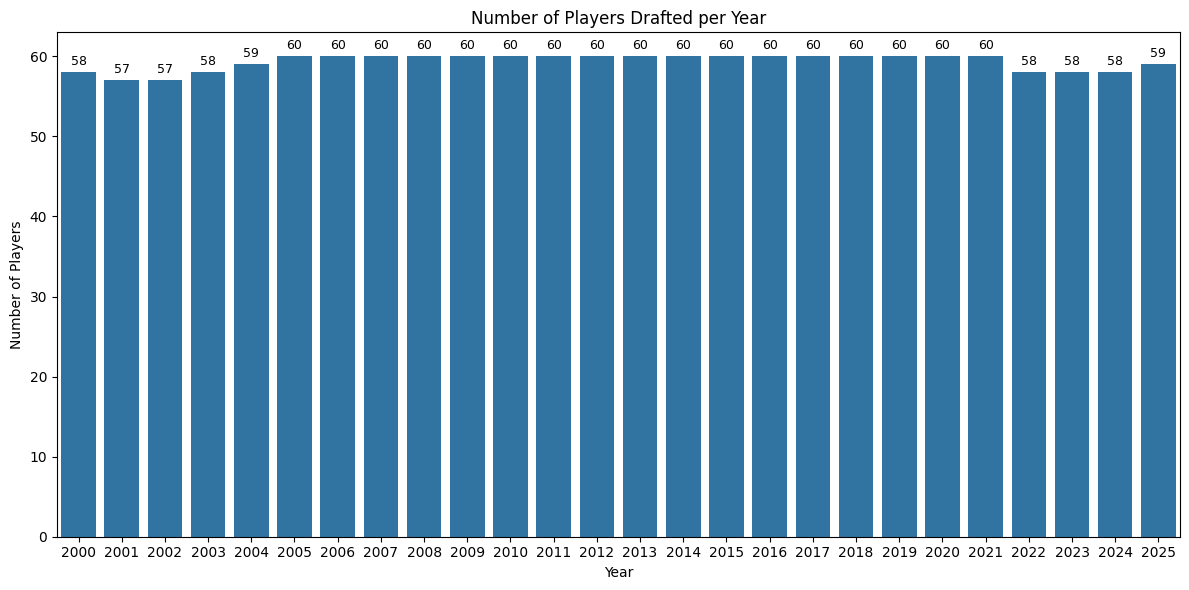

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(data=df, x="SEASON", ax=ax)
ax.set_title("Number of Players Drafted per Year")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Players")

for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(
        f"{count}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center", va="bottom",
        fontsize=9, xytext=(0, 3), textcoords="offset points"
    )

plt.tight_layout()
plt.show()

In [9]:
import pandas as pd
from pathlib import Path

current_dir = Path.cwd()
draft_combine_dir = current_dir.parent / "draft_combine"

files = list(draft_combine_dir.glob("draft_combine_20*.csv"))

df = pd.DataFrame()
for file in files:
    curr_df = pd.read_csv(file)
    df = pd.concat([df, curr_df])

df = df.sort_values(by=["SEASON"]) 
df.to_csv(draft_combine_dir / "draft_combines.csv", index=False)


In [11]:
draft_combine_df = pd.read_csv(draft_combine_dir / "draft_combines.csv")
draft_df = pd.read_csv(draft_dir / "drafts.csv")


# --- merge both datasets (keep all columns from both) ---
merged_df = pd.merge(
    draft_combine_df,
    draft_df,
    left_on=["PLAYER_ID", "SEASON"],
    right_on=["PERSON_ID", "SEASON"],
    how="inner",
    suffixes=("_COMBINE", "_DRAFT")
)

# Remove duplicate rows
merged_df = merged_df.drop_duplicates()

# --- save merged file ---
output_path = draft_dir / "drafts_with_combine_result.csv"
merged_df.to_csv(output_path, index=False)


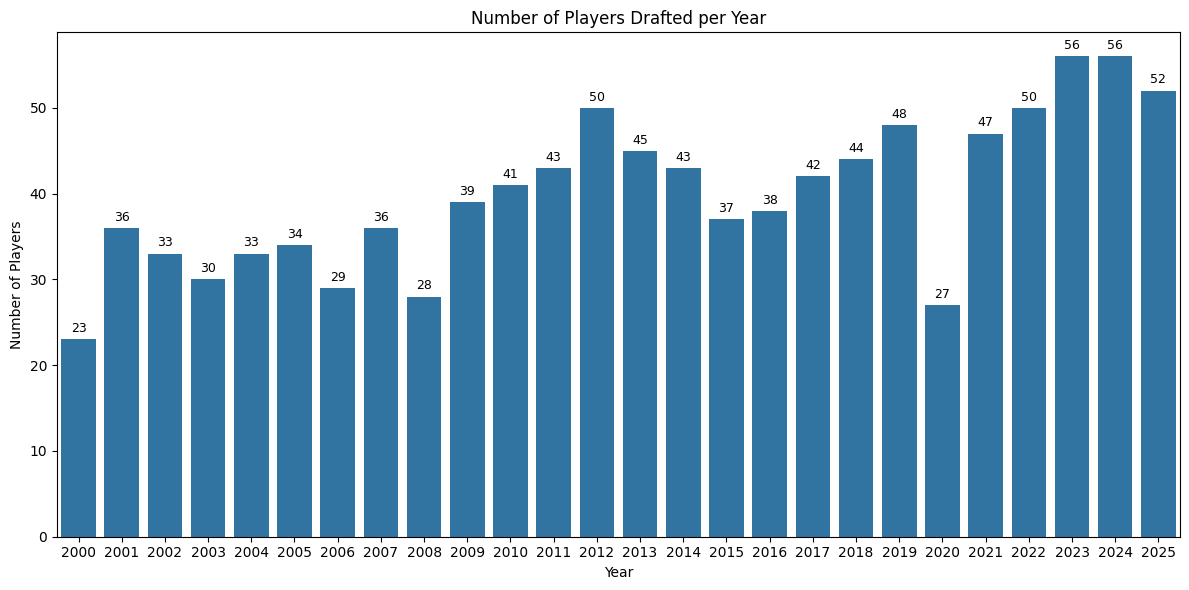

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(data=merged_df, x="SEASON", ax=ax)
ax.set_title("Number of Players Drafted per Year")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Players")

for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(
        f"{count}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center", va="bottom",
        fontsize=9, xytext=(0, 3), textcoords="offset points"
    )

plt.tight_layout()
plt.show()

### Data Preprocessing

In [13]:
df = pd.read_csv(draft_dir / "drafts_with_combine_result.csv")

In [14]:
"""
Purpose: remove duplicate/overlapping columns created by the merge and enforce one row per player-season

1.PLAYER_ID and PERSON_ID are the same after merge -> keep one
2.PLAYER_NAME_COMBINE and PLAYER_NAME_DRAFT are the same -> keep one standardized name

"""
drop_cols = [c for c in ["PERSON_ID", "PLAYER_NAME_DRAFT"] if c in df.columns]
df = df.drop(columns=drop_cols)

if "PLAYER_NAME_COMBINE" in df.columns:
    df = df.rename(columns={"PLAYER_NAME_COMBINE": "PLAYER_NAME"})

# Remove column 'DRAFT_TYPE' since it has only one value
df = df.drop(columns=["DRAFT_TYPE"])

print("Number of duplicates:", df.duplicated().sum())

Number of duplicates: 0


In [15]:
# Purpose: extract only "height without shoes" (barefoot height)
# Convert text like "6' 8''" → numeric inches
# Keep one standardized column: HEIGHT (in inches) + optional HEIGHT_CM

import pandas as pd
import re

def ft_in_to_inches(s):
    """Convert strings like 6' 8'' or 6' 8.5'' to inches. Returns None if unparsable."""
    if pd.isna(s):
        return None
    s = str(s)
    m = re.search(r"(\d+)\s*'\s*([\d\.]+)?", s)
    if not m:
        return None
    feet = float(m.group(1))
    inches = float(m.group(2)) if m.group(2) is not None else 0.0
    return round(feet * 12 + inches, 2)

# --- Convert only HEIGHT_WO_SHOES_FT_IN ---
if "HEIGHT_WO_SHOES_FT_IN" in df.columns:
    df["HEIGHT"] = df["HEIGHT_WO_SHOES_FT_IN"].apply(ft_in_to_inches)

# --- Optional: add centimeters version ---
df["HEIGHT_CM"] = df["HEIGHT"] * 2.54

# --- Drop redundant height columns explicitly ---
cols_to_drop = [
    "HEIGHT_WO_SHOES",         # numeric version (duplicate info)
    "HEIGHT_WO_SHOES_FT_IN",   # original text form (we’ve extracted from it)
    "HEIGHT_W_SHOES",          # height with shoes (not needed)
    "HEIGHT_W_SHOES_FT_IN"     # text version with shoes
]
df = df.drop(columns=cols_to_drop, errors="ignore")

# --- Quick verification ---
print(df[["PLAYER_NAME", "HEIGHT", "HEIGHT_CM"]].head())

      PLAYER_NAME  HEIGHT  HEIGHT_CM
0  Jamal Crawford    76.5     194.31
1     Mark Madsen    80.0     203.20
2      Dan Langhi    81.0     205.74
3    Mark Karcher    76.0     193.04
4     Marko Jaric    78.5     199.39


In [16]:
# Purpose: ensure numeric columns are true numbers (floats/ints), not strings

numeric_cols = [
    "HEIGHT_WO_SHOES", "HEIGHT_W_SHOES", "WEIGHT", "WINGSPAN",
    "STANDING_REACH", "BODY_FAT_PCT", "HAND_LENGTH", "HAND_WIDTH",
    "STANDING_VERTICAL_LEAP", "MAX_VERTICAL_LEAP",
    "LANE_AGILITY_TIME", "MODIFIED_LANE_AGILITY_TIME",
    "THREE_QUARTER_SPRINT", "BENCH_PRESS",
    "ROUND_NUMBER", "ROUND_PICK", "OVERALL_PICK", "TEAM_ID", "PLAYER_PROFILE_FLAG"
]
existing_numeric_cols = [c for c in numeric_cols if c in df.columns]
df[existing_numeric_cols] = df[existing_numeric_cols].apply(pd.to_numeric, errors="coerce")

df[existing_numeric_cols].dtypes

WEIGHT                        float64
WINGSPAN                      float64
STANDING_REACH                float64
BODY_FAT_PCT                  float64
HAND_LENGTH                   float64
HAND_WIDTH                    float64
STANDING_VERTICAL_LEAP        float64
MAX_VERTICAL_LEAP             float64
LANE_AGILITY_TIME             float64
MODIFIED_LANE_AGILITY_TIME    float64
THREE_QUARTER_SPRINT          float64
BENCH_PRESS                   float64
ROUND_NUMBER                    int64
ROUND_PICK                      int64
OVERALL_PICK                    int64
TEAM_ID                         int64
PLAYER_PROFILE_FLAG             int64
dtype: object

In [17]:
df.to_csv("nba.csv", index=False)

## Feature Engineering

In [18]:
# Purpose: add useful derived features for downstream analysis or modeling

# BMI = weight (lb) / height^2 (in^2) * 703, using HEIGHT_W_SHOES_INCHES if available
if {"WEIGHT", "HEIGHT_W_SHOES_INCHES"}.issubset(df.columns):
    df["BMI"] = (df["WEIGHT"] / (df["HEIGHT_W_SHOES_INCHES"] ** 2)) * 703

# Vertical ratio: leap relative to height without shoes
if {"MAX_VERTICAL_LEAP", "HEIGHT_WO_SHOES"}.issubset(df.columns):
    df["VERTICAL_RATIO"] = df["MAX_VERTICAL_LEAP"] / df["HEIGHT_WO_SHOES"]

In [19]:
# Purpose: generate a CSV report showing total rows, non-missing counts,
#          missing counts, and missing percentage for each column.

import pandas as pd

# --- Basic dataset stats ---
total_rows = len(df)
total_columns = df.shape[1]

# --- Compute completeness metrics ---
missing_report = pd.DataFrame({
    "column": df.columns,
    "total_count": total_rows,
    "non_missing_count": df.notna().sum(),
    "missing_count": df.isna().sum(),
    "missing_percent": (df.isna().mean() * 100).round(2)
}).sort_values(by="missing_count", ascending=False)

# --- Save report ---
output_path = draft_dir / "missing_values_report.csv"
missing_report.to_csv(output_path, index=False)

# --- Display summary ---
print(f"✅ Missing value report saved to: {output_path}")
print(f"🧾 Total rows: {total_rows} | Total columns: {total_columns}\n")

✅ Missing value report saved to: /Users/tenzin/Desktop/mycodes/nba-draft-ranker/drafts/missing_values_report.csv
🧾 Total rows: 1040 | Total columns: 55



In [20]:
df.to_csv("draft_combine.csv", index=False)

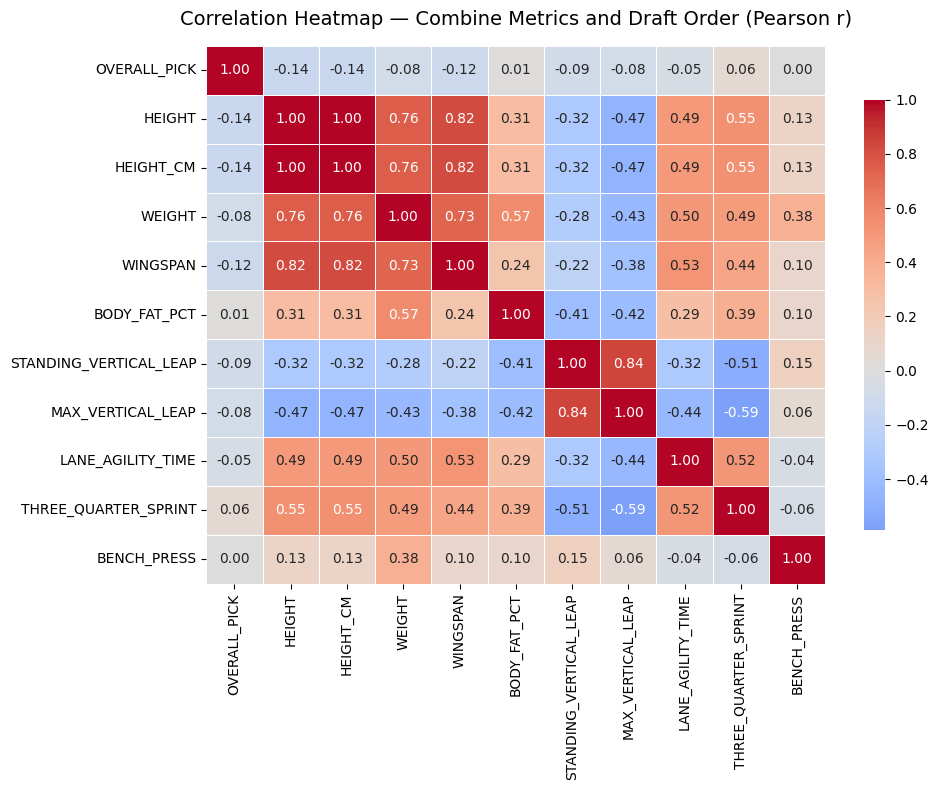

In [21]:
# Purpose: visualize overall correlation structure among key combine metrics and draft order
# (lower OVERALL_PICK = better player)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Select meaningful features ---
corr_features = [
    "OVERALL_PICK",
    "HEIGHT", "HEIGHT_CM", "WEIGHT", "WINGSPAN",
    "BODY_FAT_PCT", "BMI",
    "STANDING_VERTICAL_LEAP", "MAX_VERTICAL_LEAP",
    "LANE_AGILITY_TIME", "THREE_QUARTER_SPRINT", "BENCH_PRESS"
]

# --- Filter to existing columns ---
corr_features = [c for c in corr_features if c in df.columns]
corr_df = df[corr_features].dropna()

# --- Compute correlation matrix ---
corr_matrix = corr_df.corr(numeric_only=True)

# --- Plot heatmap ---
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Heatmap — Combine Metrics and Draft Order (Pearson r)", fontsize=14, pad=15)
plt.tight_layout()
plt.show()

- Size metrics (height, weight, wingspan) correlate strongly with each other but weakly with draft order.  
- Body fat shows slight positive relation with later picks.  
- Overall, combine stats show little linear link to draft position.

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

core_features = [
    "OVERALL_PICK", "HEIGHT", "WEIGHT", "WINGSPAN", "BODY_FAT_PCT", "BMI",
    "STANDING_VERTICAL_LEAP", "MAX_VERTICAL_LEAP",
    "LANE_AGILITY_TIME", "THREE_QUARTER_SPRINT", "BENCH_PRESS"
]

sns.pairplot(df[core_features].dropna(), diag_kind="kde", corner=True)
plt.suptitle("Pairwise Relationships of Combine Metrics vs Draft Pick", y=1.02)
plt.show()


KeyError: "['BMI'] not in index"

In [ ]:
spearman_corr = df[core_features].corr(method="spearman", numeric_only=True)["OVERALL_PICK"].sort_values()
plt.figure(figsize=(8,5))
plt.barh(spearman_corr.index, spearman_corr.values, color="tab:blue")
plt.title("Spearman Rank Correlation with Draft Order")
plt.xlabel("Spearman ρ (monotonic relationship)")
plt.axvline(0, color="black", lw=1)
plt.tight_layout()
plt.show()


_This Spearman chart confirms what the pairplot hinted — raw physical combine numbers have almost no monotonic relationship with draft position overall._

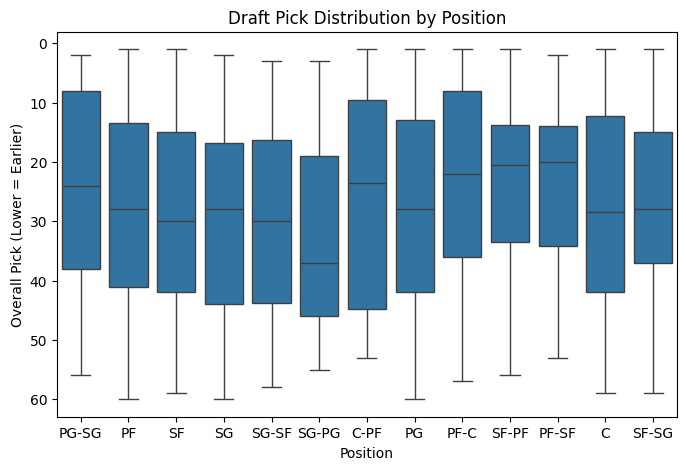

In [23]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="POSITION", y="OVERALL_PICK")
plt.title("Draft Pick Distribution by Position")
plt.ylabel("Overall Pick (Lower = Earlier)")
plt.xlabel("Position")
plt.gca().invert_yaxis()  # smaller = better
plt.show()
